In [3]:
import numpy as np
import scipy as sp
import scipy.signal
from matplotlib import pyplot as plt

from bbcpy.datatypes.srm_eeg import SRM_Data_Subject

from bbcpy.datatypes.utils import *
from bbcpy.load.srm_eeg import *
module_path = os.path.abspath(os.path.join('../../bbcpy_AutoML/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import datasets.vis as vis

In [4]:
srm_metadata_path = "../local/data/SMR/metadata/"
subject_group_path = list_all_files(srm_metadata_path, pattern="*.json")

In [9]:
def proc_spatialFilter(cnt, clab, chan, neighbors='*'):
    '''
    Usage:
        cnt_sf = proc_spatialFilter(cnt, clab, chan, neighbors='*')
    Parameters:
        cnt:       a 2D array of multi-channel timeseries (size: channels x samples),
        clab:      a 1D array of channel names  (size: channels)
        chan:      channel of center location
        neighbors: labels of channels that are to be subtracted 
    Returns:
        cnt_sf:    timeseries of spatially filtered channel (size: 1 x samples)
    Examples:
        cnt_c4_bip = proc_spatialFilter(cnt, clab, 'C4', 'CP4')
        cnt_c4_lap = proc_spatialFilter(cnt, clab, 'C4', ['C2','C6','FC4','CP4'])
        cnt_c4_car = proc_spatialFilter(cnt, clab, 'C4', '*')
    '''
    cidx= clab.index(chan)
    if isinstance(neighbors, list):
        nidx = [clab.index(cc) for cc in neighbors]
    elif neighbors == '*':
        nidx = range(len(clab))   # Common Average Reference (CAR)
    else:
        nidx = [clab.index(neighbors)]
    cnt_sf = cnt[[cidx],:] - np.mean(cnt[nidx,:], axis=0)
    return cnt_sf

def signed_r_square(epo, y):
    '''
    Synopsis:
        epo_r = signed_r_square(epo, y)
    Arguments:
        epo:    3D array of segmented signals (time x channels x epochs), 
                see makeepochs
        y:      labels with values 0 and 1 (1 x epochs)
    Output:
        epo_r:  2D array of signed r^2 values (time x channels)
    '''
    epo0 = epo[:, :, y==0]
    epo1 = epo[:, :, y==1]
    N1 = epo0.shape[2]
    N2 = epo1.shape[2]
    const = np.float(N1*N2) / ((N1+N2)**2)
    mudiff = epo0.mean(axis=2) - epo1.mean(axis=2)
    var = epo.var(axis=2)
    return np.sign(mudiff) * const * (mudiff)**2 / var

In [10]:
import numpy as np
def plot_PSD(epo, fs, mrk_class):
    X1 = epo[mrk_class==0,0, :]
    X2 = epo[mrk_class==1,0, :]
    f1, X1psd = sp.signal.welch(X1.flatten('F'), fs=fs)
    f2, X2psd = sp.signal.welch(X2.flatten('F'), fs=fs)

    plt.semilogy(f1, X1psd)
    plt.semilogy(f2, X2psd)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [$uV^2$/Hz]')

In [6]:
ival = '0s:10s:10ms'
# ival = 'all'
bands = None
# select a subject number and its sessions to load, you can find the data in this link :
# https://figshare.com/articles/dataset/Human_EEG_Dataset_for_Brain-Computer_Interface_and_Meditation/13123148
srm_data_root_path = "../local/data/SMR/raw"
srm_subject_1 = SRM_Data_Subject(subject_id=1, srm_data_path=srm_data_root_path, sessions_ids=[1, 2, 3])
epo_data_s1 = srm_subject_1.create_subject_object(bands=bands,
                                                  sessions_ids=[1],
                                                  classes=["R", "L"],
                                                  select_chans=['C*', 'FC*'],
                                                  select_timepoints=ival)

INFO:root:Session 1 loaded; has the shape: (155, 23, 1000)


In [13]:
fs = epo_data_s1.fs
C3, C4 = epo_data_s1.chans.index('C3'), epo_data_s1.chans.index('C4')
# NOTE: Do spatial filtering
epo_sf = epo_data_s1.copy()
epo_sf[C3] = proc_spatialFilter(epo_data_s1, epo_data_s1.chans, 'C3', neighbors='CP3')
epo_sf[C4] = proc_spatialFilter(epo_data_s1, epo_data_s1.chans, 'C4', neighbors=['C2','C6','FC4','CP4'])
clab_flt = ['C3-CP3', 'C4 lap']

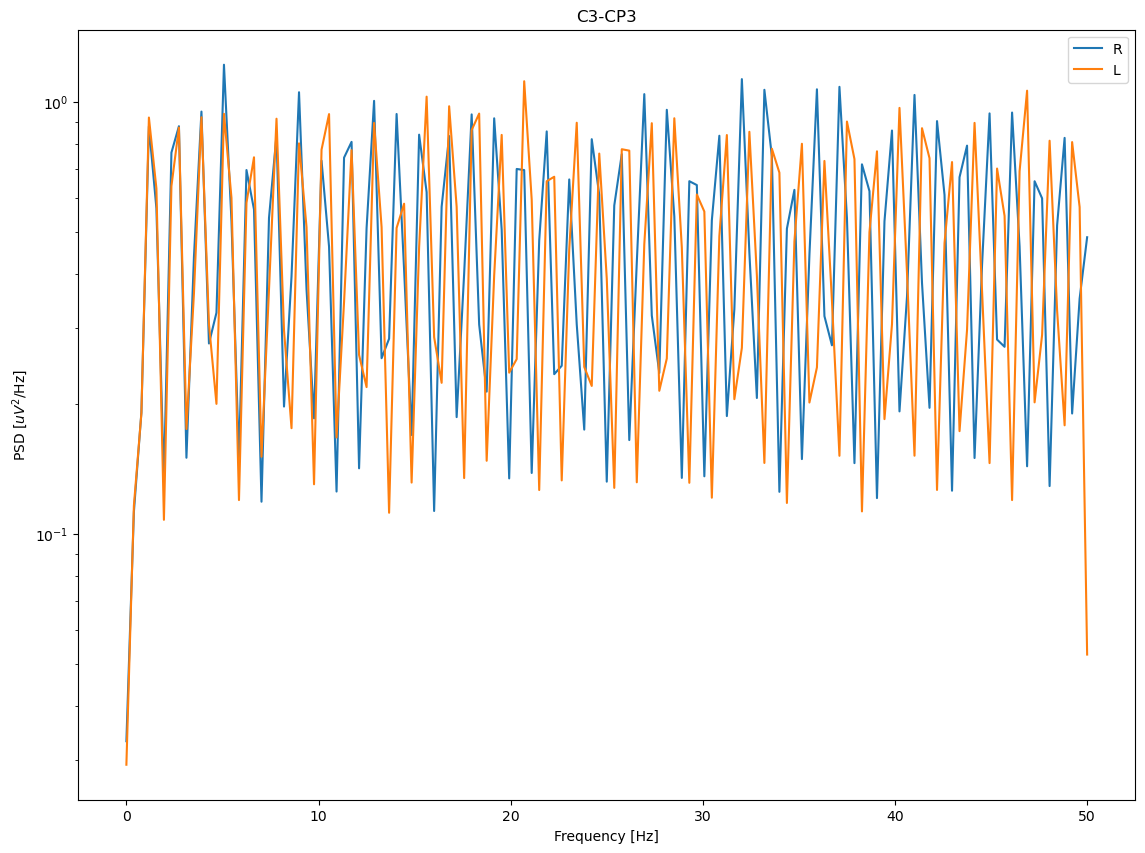

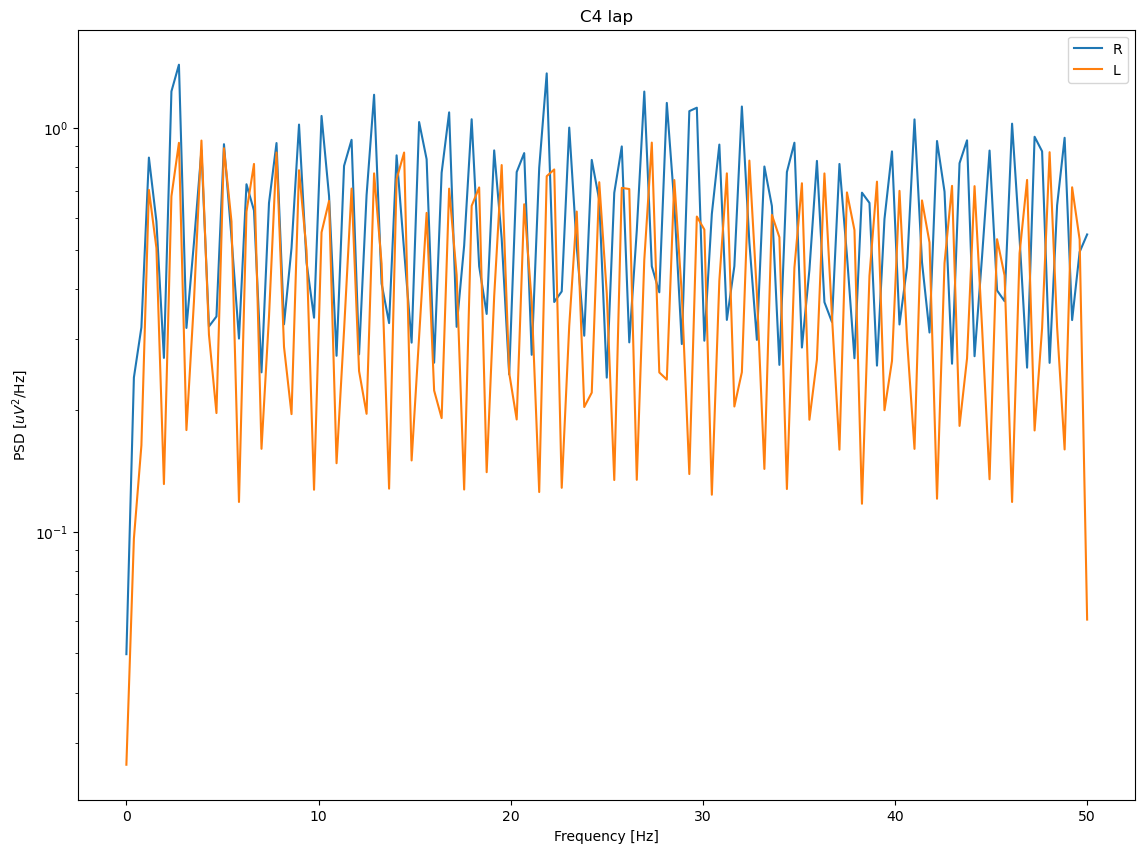

In [14]:
plt.figure(figsize=[30, 10])
plt.subplot(121)
plot_PSD(epo_sf[:,C3,:], fs, epo_sf.y)
plt.title(clab_flt[0])
plt.legend(epo_sf.className)

plt.figure(figsize=[30, 10])
plt.subplot(122)
plot_PSD(epo_sf[:,C4,:], fs,epo_sf.y)
plt.title(clab_flt[1])
plt.legend(epo_sf.className)


In [15]:
band = np.array([8, 30]) # "." is crucial!

In [16]:
c3 = epo_sf[:,C3,:]
c4 = epo_sf[:,C4,:]
clab_flt = ['C3-CP3', 'C4 lap']

Wn = band / fs * 2
b, a = scipy.signal.butter(5, Wn, btype='bandpass')
cnt_flt = np.concatenate((c3, c4), axis=1)

cnt_flt = sp.signal.lfilter(b, a, cnt_flt)
cnt_hull = np.abs(sp.signal.hilbert(cnt_flt, axis=1))

erd0 = np.mean(cnt_hull.T[:,:,c3.y==0], axis=2)
erd1 = np.mean(cnt_hull.T[:,:,c3.y==1], axis=2)

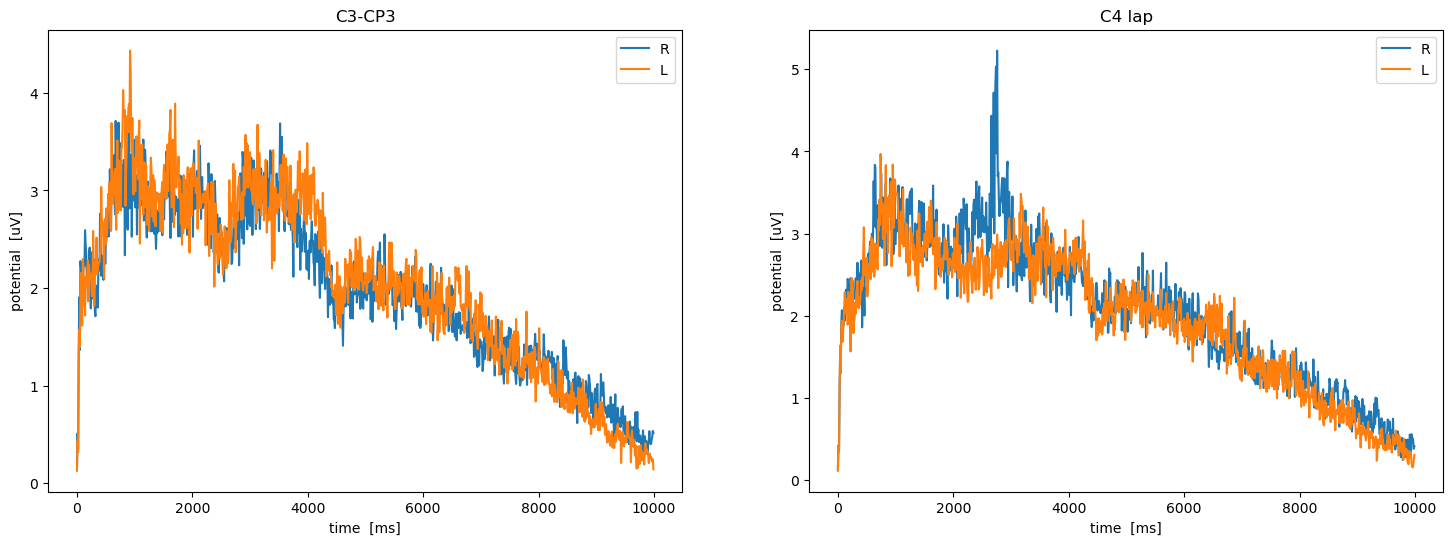

In [17]:
plt.figure(figsize=[18, 6])
nChans= 2
for i in range(nChans):
    plt.subplot(1, nChans, i+1)
    plt.plot(c3.t, erd0[:, i], label=c3.className[0])
    plt.plot(c3.t, erd1[:, i], label=c3.className[1])
    plt.title(clab_flt[i])
    plt.xlabel('time  [ms]')
    plt.ylabel('potential  [uV]')
    plt.legend()

## ERD in bbcpy

In [2]:
import os 
import sys
import copy
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import mlflow
import dask as dd
import yellowbrick 
import scipy.io as sio

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import KFold, ShuffleSplit, GridSearchCV
from sklearn.model_selection import cross_val_score

from bbcpy.pipeline import make_pipeline
import bbcpy.functions.helpers as helpers
from bbcpy.functions.base import ImportFunc
from bbcpy.functions.spatial import CSP, MBCSP
from bbcpy.functions.artireject import AverageVariance
from bbcpy.functions.statistics import cov

from bbcpy.datatypes.srm_eeg import SRM_Data_Subject
import bbcpy

In [5]:
ival = '0s:11s:10ms' # freq = 100 hz
# ival = 'all'
bands = [8, 14]
# select a subject number and its sessions to load, you can find the data in this link :
# https://figshare.com/articles/dataset/Human_EEG_Dataset_for_Brain-Computer_Interface_and_Meditation/13123148
srm_data_root_path = "../local/data/SMR/raw"
srm_subject_1 = SRM_Data_Subject(subject_id=1, srm_data_path=srm_data_root_path)
epo_data_s1 = srm_subject_1.create_subject_object(bands=bands,
                                                  sessions_ids="all",
                                                  classes=["R", "L"],
                                                  select_chans=['*'],
                                                  select_timepoints=ival)

INFO:root:Loading all sessions for subject 1, the following sessions will be loaded: ['Session_1', 'Session_10', 'Session_11', 'Session_2', 'Session_3', 'Session_4', 'Session_5', 'Session_6', 'Session_7', 'Session_8', 'Session_9']
INFO:root:Loading session Session_1 for subject S1
C:\Users\alioo\Desktop\MA\bbcpy_AutoML\bbcpy\bbcpy\datatypes\srm_eeg.py:562: UserWarning: Filtering the epoched data is not optimal due to filter artefacts. Consider filtering the continuous data before segmentation.
  warnings.warn(
INFO:root:Session Session_1 loaded; has the shape: (155, 62, 1100)
INFO:root:Loading session Session_10 for subject S1
INFO:root:Session Session_10 loaded; has the shape: (187, 62, 1100)
C:\Users\alioo\miniconda3\envs\bbcpy_AutoML\lib\site-packages\numpy\lib\arraysetops.py:733: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
INFO:root: subject 1 with new appended session Session_10 

In [6]:
hilbilly = bbcpy.functions.base.ImportFunc(signal.hilbert, outClass='same', axis=-1)
ERD1 = np.abs(hilbilly(epo_data_s1))

In [10]:
ERD1.className[0]

'R'

NameError: name 'imagVPaw' is not defined

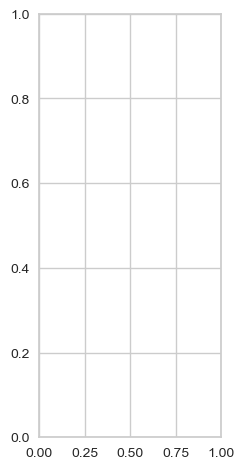

In [8]:
plt.figure()
plt.subplot(131)
bbcpy.visual.scalp.map(epo_data_s1, ERD1.classmean(0)[0, :, '3s'])
plt.subplot(132)
bbcpy.visual.scalp.map(epo_data_s1, ERD1.classmean(1)[0, :, '3s'])
plt.subplot(133)
bbcpy.visual.scalp.map(epo_data_s1, ERD1.classmean(1)[0, :, '3s'] - ERD1.classmean(0)[0, :, '3s'])
plt.figure()
plt.subplot(211)
plt.plot(ERD1.t, np.squeeze(ERD1.classmean()[:, 'C3']).T)
plt.subplot(212)
plt.plot(ERD1.t, np.squeeze(ERD1.classmean()[:, 'C4']).T)
plt.show()